In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize,PowerNorm
import matplotlib.cm as cm
from tqdm.auto import tqdm

import warnings

In [2]:
from PoissonCircLoss1 import CircLoss

In [3]:
torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
class PINNModel(nn.Module):
    def __init__(self, layer_sizes):
        super(PINNModel, self).__init__()
        layers = []
        for i in range(len(layer_sizes) - 1):
            layers.append(torch.nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            if i < len(layer_sizes) - 2:
                layers.append(torch.nn.Tanh())
        self.net = torch.nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

# Initialize the models
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 定义 model1: [2, 20, 20, 1]
model1 = PINNModel([2, 20, 20, 1]).to(device)

# 定义 model2: [2, 30, 30, 30, 1]
model2 = PINNModel([2, 20, 20, 1]).to(device)

model = [model1, model2]
def K1(x, y):
    return (x**2-y**2+3)/7

def K2(x, y):
    return (2+x*y)/5

# 创建 CircLoss 类的实例并传入 K1 和 K2 函数
ls_circ = CircLoss(n_points=15000, int_pts=500, bound_pts=200,internal_points=1000, external_points=800, K=[K1, K2])

optimizer1 = optim.Adam(model1.parameters())
optimizer2 = optim.Adam(model2.parameters())

num_epochs = 30000  # 训练的总 epoch 数

# Training loop
for epoch in range(num_epochs):
    model1.train()
    model2.train()
    optimizer1.zero_grad()
    optimizer2.zero_grad()

    # 传入 model 和 epoch 作为 iteration，计算损失
    loss, loss_pde1,  loss_pde2, loss_interface,loss_boundary = ls_circ.loss(model)

    loss.backward()  # 保留计算图，便于自适应采样使用
    optimizer1.step()
    optimizer2.step()

    # Print training information (optional)
    # Print training information (optional)
    if epoch % 200 == 0:  # Print every 200 iterations
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.6f}, '
            f'Loss1: {loss_pde1.item():.6f}, '
            f'Loss2: {loss_pde2.item():.6f}, '
            f'Lossin: {loss_interface.item():.6f}, '
            f'Lossbc: {loss_boundary.item():.6f}')

# Plotting the results after training
 

c:\Users\gagan\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\autograd\graph.py:744: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ..\aten\src\ATen\cuda\CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [0/30000], Loss: 13.070234, Loss1: 0.803189, Loss2: 0.029148, Lossin: 0.562024, Lossbc: 11.675873
Epoch [200/30000], Loss: 0.218208, Loss1: 0.010734, Loss2: 0.159208, Lossin: 0.015425, Lossbc: 0.032841
Epoch [400/30000], Loss: 0.115167, Loss1: 0.001780, Loss2: 0.087768, Lossin: 0.007090, Lossbc: 0.018529
Epoch [600/30000], Loss: 0.039499, Loss1: 0.001260, Loss2: 0.027002, Lossin: 0.002978, Lossbc: 0.008260
Epoch [800/30000], Loss: 0.011624, Loss1: 0.000960, Loss2: 0.005037, Lossin: 0.001706, Lossbc: 0.003921
Epoch [1000/30000], Loss: 0.006267, Loss1: 0.000679, Loss2: 0.002181, Lossin: 0.001142, Lossbc: 0.002266
Epoch [1200/30000], Loss: 0.004252, Loss1: 0.000470, Loss2: 0.001567, Lossin: 0.000734, Lossbc: 0.001481
Epoch [1400/30000], Loss: 0.002983, Loss1: 0.000312, Loss2: 0.001218, Lossin: 0.000463, Lossbc: 0.000990
Epoch [1600/30000], Loss: 0.002094, Loss1: 0.000196, Loss2: 0.000955, Lossin: 0.000292, Lossbc: 0.000651
Epoch [1800/30000], Loss: 0.001461, Loss1: 0.000116, Loss2: 

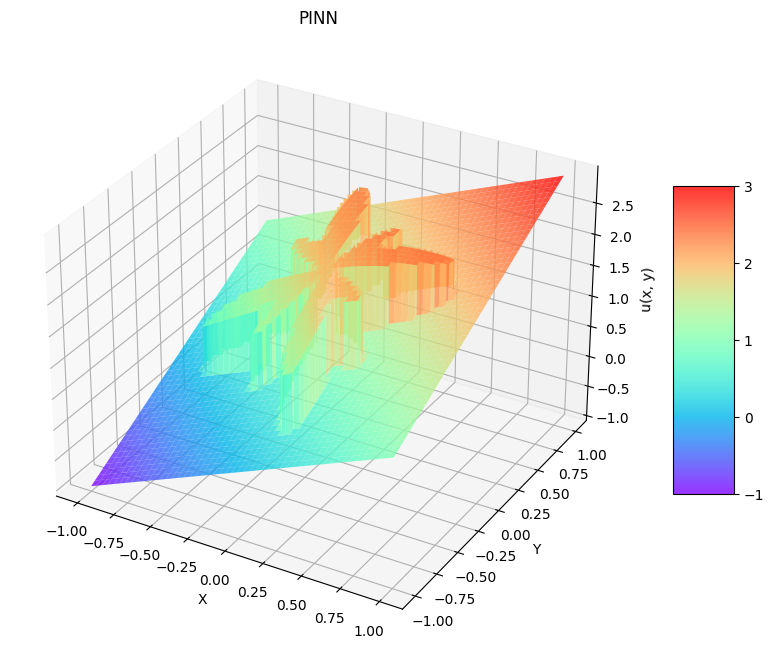

In [9]:
# Define grid and points
x = np.linspace(-1, 1, 1000)
y = np.linspace(-1, 1, 1000)
X, Y = np.meshgrid(x, y)

# Convert to PyTorch tensor
X_tensor = torch.tensor(X, dtype=torch.float32)
Y_tensor = torch.tensor(Y, dtype=torch.float32)
XY_tensor = torch.stack([X_tensor, Y_tensor], dim=-1)  # Stack to create a 2D tensor

# Compute polar coordinates angle
theta = torch.atan2(Y_tensor, X_tensor)

# Compute petal radius
x_petal = (0.40178 + 0.40178 * torch.cos(2 * theta) * torch.sin(6 * theta)) * torch.cos(theta)
y_petal = (0.40178 + 0.40178 * torch.cos(2 * theta) * torch.sin(6 * theta)) * torch.sin(theta)
r_petal_interp = torch.sqrt(x_petal**2 + y_petal**2)

# Compute each point's radius
r_grid = torch.sqrt(X_tensor**2 + Y_tensor**2)

# Determine points belonging to U1 or U2
mask_U1 = r_grid < r_petal_interp
mask_U2 = r_grid > r_petal_interp

# Initialize U1 and U2 with NaN values
U1 = torch.full(X_tensor.shape, float('nan'), dtype=torch.float32).cpu()
U2 = torch.full(X_tensor.shape, float('nan'), dtype=torch.float32).cpu()

# Prepare tensors for U1 and U2 based on masks
XY_U1 = XY_tensor[mask_U1].to(device)
XY_U2 = XY_tensor[mask_U2].to(device)

# Pass through models
with torch.no_grad():
    U1[mask_U1] = model1(XY_U1).squeeze().cpu()
    U2[mask_U2] = model2(XY_U2).squeeze().cpu()

# Reshape to grid shape
U1_grid = U1.numpy()
U2_grid = U2.numpy()

# 初始化解，将U1和U2的结果放入一个整体的U解中
U_combined = np.full_like(U1_grid, np.nan)

# 分区域赋值
U_combined[mask_U1.cpu().numpy()] = U1_grid[mask_U1.cpu().numpy()]  # 对应 U1 区域
U_combined[mask_U2.cpu().numpy()] = U2_grid[mask_U2.cpu().numpy()]  # 对应 U2 区域

# 创建三维立体图
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# 使用颜色映射
cmap = plt.get_cmap('rainbow')

# 在界面处设置 NaN，避免显示颜色（确保边界更清晰）
U_combined = np.where(np.abs(U1_grid - U2_grid) < 1e-3, np.nan, U_combined)

# 绘制区域，调整透明度
surf = ax.plot_surface(X, Y, U_combined, cmap=cmap, edgecolor='none', alpha=0.8)

# 设置颜色条范围
surf.set_clim(-1, 3)  # 使用 surf 对象设置 clim

# 添加颜色条
colorbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
colorbar.set_ticks(np.linspace(-1, 3, num=5))  # 设置颜色条范围为-1到3

# 设置标题和标签
ax.set_title('PINN')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('u(x, y)')

plt.show()

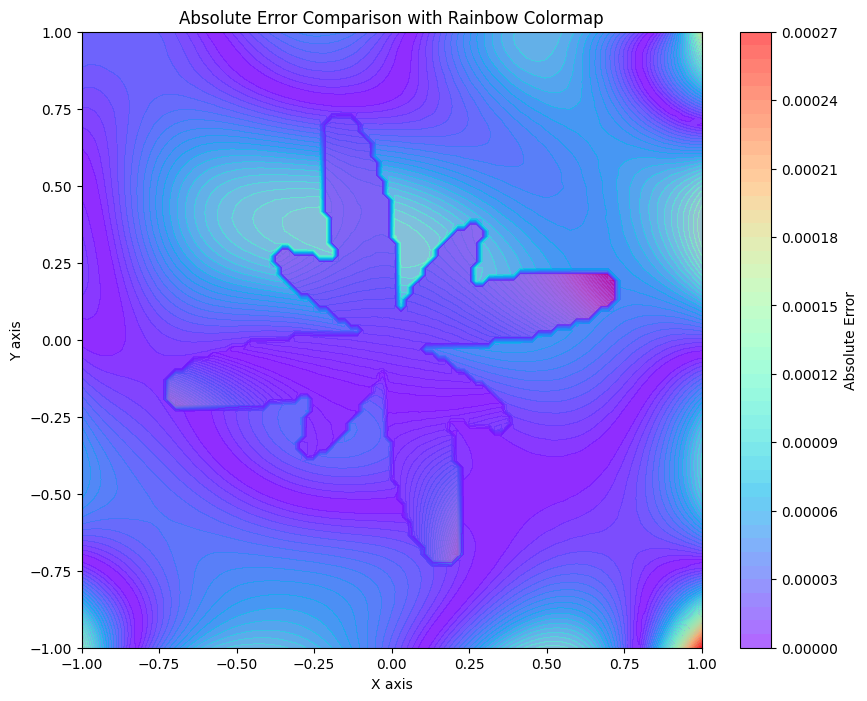

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# 定义网格数据
x = np.linspace(-1, 1, 100)  # 100个点
y = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x, y)

# 转换为 PyTorch 张量
X_tensor = torch.tensor(X, dtype=torch.float32)
Y_tensor = torch.tensor(Y, dtype=torch.float32)

# 计算花瓣函数
theta = torch.arctan2(Y_tensor, X_tensor)
theta = torch.where(theta < 0, theta + 2 * torch.pi, theta)
x_petal = (0.40178 + 0.40178 * torch.cos(2 * theta) * torch.sin(6 * theta)) * torch.cos(theta)
y_petal = (0.40178 + 0.40178 * torch.cos(2 * theta) * torch.sin(6 * theta)) * torch.sin(theta)
r_petal_interp = torch.sqrt(x_petal**2 + y_petal**2)

# 计算每个点的半径
r_grid = torch.sqrt(X_tensor**2 + Y_tensor**2)

# 确定属于 U1 或 U2 的点
mask_U1 = r_grid < r_petal_interp
mask_U2 = r_grid >= r_petal_interp

# 计算真实解
u1_true = np.sin(X + Y) + np.cos(X + Y) + 1
u2_true = X + Y + 1

# 计算预测解 (假设 model1 和 model2 已经训练好并可以进行预测)
XY = torch.tensor(np.stack([X.ravel(), Y.ravel()], axis=1), dtype=torch.float32).to(device)
outputs = [model1(XY).detach().cpu().numpy().reshape(X.shape), model2(XY).detach().cpu().numpy().reshape(X.shape)]
u1_pred, u2_pred = outputs

# 计算绝对误差
abs_error_u1 = np.zeros_like(u1_true)
abs_error_u2 = np.zeros_like(u2_true)

# 填充绝对误差
abs_error_u1[mask_U1.numpy()] = np.abs(u1_true[mask_U1.numpy()] - u1_pred[mask_U1.numpy()])
abs_error_u2[mask_U2.numpy()] = np.abs(u2_true[mask_U2.numpy()] - u2_pred[mask_U2.numpy()])

# 绘制绝对误差图
plt.figure(figsize=(10, 8))

# 绘制绝对误差
plt.contourf(X, Y, abs_error_u1, levels=50, cmap='rainbow', alpha=0.6)
plt.contourf(X, Y, abs_error_u2, levels=50, cmap='rainbow', alpha=0.6)

# 添加颜色条
plt.colorbar(label='Absolute Error')

# 设置图形标题和标签
plt.title('Absolute Error Comparison with Rainbow Colormap')
plt.xlabel('X axis')
plt.ylabel('Y axis')

plt.show()


In [7]:
def adapt_sampling(self):
    # 如果损失超过阈值，重新采样并增加采样密度
    x = torch.rand(self.n_points) * 2 - 1
    y = torch.rand(self.n_points) * 2 - 1
    self.W = torch.stack((x, y), dim=1).reshape(-1, 2)
    
    # 重新计算内部和外部的点，并增加采样密度
    xx, yy = self.W[:, 0], self.W[:, 1]
    theta = torch.arctan2(self.W[:, 1], self.W[:, 0])
    theta = torch.where(theta < 0, theta + 2 * torch.pi, theta)
    x_petal = (0.40178 + 0.40178 * torch.cos(2 * theta) * torch.sin(6 * theta)) * torch.cos(theta)
    y_petal = (0.40178 + 0.40178 * torch.cos(2 * theta) * torch.sin(6 * theta)) * torch.sin(theta)
    mask1 = xx**2 + yy**2 < x_petal**2 + y_petal**2
    mask2 = xx**2 + yy**2 > x_petal**2 + y_petal**2
    
    internal_points = self.W[mask1]
    external_points = self.W[mask2]
    
    # 增加采样点数量
    self.W1 = internal_points[:min(len(internal_points), self.int_pts * 2)].to(self.device)
    self.W2 = external_points[:min(len(external_points), self.bound_pts * 2)].to(self.device)
# Training loop
for epoch in range(num_epochs):
    model1.train()
    model2.train()
    optimizer1.zero_grad()
    optimizer2.zero_grad()

    # Compute losses
    loss,_,_,_,_ = ls_circ.loss(model)

    # 如果损失超过阈值，进行自适应采样
    if loss.item() > 1e-3:
        print(f'Loss exceeded threshold at epoch {epoch}, adapting sampling...')
        ls_circ.adapt_sampling()

    # Backpropagation and optimization
    loss.backward()
    optimizer1.step()
    optimizer2.step()

    # Print training information (optional)
    if epoch % 200 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [0/30000], Loss: 0.0000
Epoch [200/30000], Loss: 0.0000
Epoch [400/30000], Loss: 0.0000
Epoch [600/30000], Loss: 0.0000
Epoch [800/30000], Loss: 0.0000
Epoch [1000/30000], Loss: 0.0000
Epoch [1200/30000], Loss: 0.0000
Epoch [1400/30000], Loss: 0.0000
Epoch [1600/30000], Loss: 0.0000
Epoch [1800/30000], Loss: 0.0000
Epoch [2000/30000], Loss: 0.0000
Epoch [2200/30000], Loss: 0.0000
Epoch [2400/30000], Loss: 0.0000
Epoch [2600/30000], Loss: 0.0000
Epoch [2800/30000], Loss: 0.0000
Epoch [3000/30000], Loss: 0.0000
Epoch [3200/30000], Loss: 0.0000
Epoch [3400/30000], Loss: 0.0000
Epoch [3600/30000], Loss: 0.0000
Epoch [3800/30000], Loss: 0.0000
Epoch [4000/30000], Loss: 0.0001
Epoch [4200/30000], Loss: 0.0000
Epoch [4400/30000], Loss: 0.0000
Epoch [4600/30000], Loss: 0.0000
Epoch [4800/30000], Loss: 0.0000
Epoch [5000/30000], Loss: 0.0000
Epoch [5200/30000], Loss: 0.0000
Epoch [5400/30000], Loss: 0.0000
Epoch [5600/30000], Loss: 0.0001
Epoch [5800/30000], Loss: 0.0000
Epoch [6000/30000